In [1]:
%load_ext autoreload
%autoreload 2
import garbageman

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd

In [3]:
street_segments = gpd.read_file("../data/processed/street_segments.geojson")
blocks = gpd.read_file("../data/processed/blocks.geojson")
buildings = gpd.read_file("../data/processed/buildings.geojson")
blockfaces = gpd.read_file("../data/processed/blockfaces.geojson")

In [4]:
trash = pd.read_excel("../data/one-month-data.xlsx")

In [7]:
from shapely.geometry import Polygon
blocks_of_interest = garbageman.pipeline.select_area_of_interest(
    blocks,
    Polygon(
        ((-122.422836714479, 37.7849452051136), 
         (-122.419309755901, 37.7849452051136), 
         (-122.419309755901, 37.7998665826739), 
         (-122.422836714479, 37.7998665826739), 
         (-122.422836714479, 37.7849452051136))
    ).buffer(0.001)
)

In [8]:
frontages_of_interest = garbageman.pipeline.calculate_frontages(blocks_of_interest, 
                                                                street_segments, blockfaces, buildings)

100%|██████████| 71/71 [01:08<00:00,  1.07it/s]


In [23]:
frontages_of_interest.sample(10)

,geoid10,sf16_BldgID,geoid10_n,geom_offset_start,geom_offset_end,geometry,sf16_BldgID_n
894,060750102002002,201006.0064911,060750102002002_3,0.65,0.72,"LINESTRING (-122.4216405 37.8007605, -122.4215...",201006.0064911_0
284,060750111003006,201006.0007007,060750111003006_3,0.0,0.2,"LINESTRING (-122.420401 37.789165, -122.420070...",201006.0007007_1
630,060750110003003,201006.0020027,060750110003003_4,0.51,1.00,"LINESTRING (-122.41966426 37.79390163, -122.41...",201006.0020027_1
96,060750120001006,201006.0002421,060750120001006_1,0.67,1.00,"LINESTRING (-122.41957117 37.78782597, -122.42...",201006.0002421_0
846,060750109002003,201006.0052810,060750109002003_1,0.12,0.18,LINESTRING (-122.4203074119338 37.796118626680...,201006.0052810_0
509,060750110003003,201006.0014374,060750110003003_4,0.0,0.29,"LINESTRING (-122.419753 37.794354, -122.419702...",201006.0014374_1
580,060750110001007,201006.0016394,060750110001007_1,0.61,1.00,"LINESTRING (-122.42000386 37.79557223, -122.41...",201006.0016394_0
216,060750111001006,201006.0004929,060750111001006_1,0.4100,0.61,"LINESTRING (-122.42136022 37.79049272, -122.42...",201006.0004929_0
917,060750109002002,201006.0074467,060750109002002_4,0.59,0.65,"LINESTRING (-122.42039244 37.79748784, -122.42...",201006.0074467_0
297,060750110003006,201006.0007402,060750110003006_4,0.27,0.4700,"LINESTRING (-122.42118221 37.79302175, -122.42...",201006.0007402_0


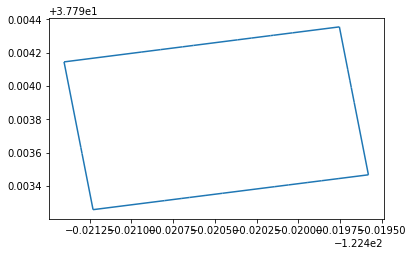

In [25]:
frontages_of_interest.query("geoid10 == '060750110003003'").plot()

In [27]:
frontages_of_interest.query("geoid10 == '060750110003003'").iloc[0]['sf16_BldgID']

'201006.0003192'

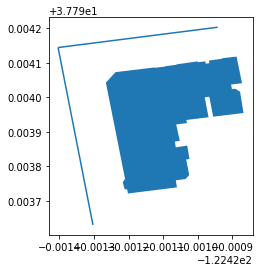

In [40]:
ax = gpd.GeoSeries(frontages_of_interest.query("geoid10 == '060750110003003'").iloc[0]).plot()
gpd.GeoSeries(frontages_of_interest.query("geoid10 == '060750110003003'").iloc[1]).plot(ax=ax)
buildings.query("sf16_BldgID == '201006.0003192'").plot(ax=ax)

In [43]:
trash = gpd.GeoDataFrame(trash, geometry=trash.apply(lambda srs: Point(srs['long'], srs['lat']),axis='columns'))

In [198]:
def frontage_index(frontages):
    import rtree
    index = rtree.index.Index()

    for idx, frontage in frontages.iterrows():
        index.insert(idx, frontage.geometry.bounds)

    return index


def assign_points_to_frontages(points, frontages, index):
    idxs = points.geometry.map(lambda g: list(f_index.nearest(g.bounds, 5)))
    frontage_groups = idxs.map(lambda idx_group: frontages.iloc[idx_group]).values
    
    out = []
    for i in range(len(points)):
        point = points.iloc[i]
        frontage_group = frontage_groups[i]
        
        distances = [nearest_distance(frontage.geometry, point.geometry) for _, frontage in frontage_group.iterrows()]
        frontage_idx = np.argmin(distances)
        out.append(frontages.iloc[frontage_group.index[frontage_idx]])
        
    return pd.concat(out, axis='columns').T.sf16_BldgID_n

In [202]:
def nearest_distance(line, point):
    proj_pos = line.project(point, normalized=True)
    proj_point = line.interpolate(proj_pos, normalized=True)
    dist = proj_point.distance(point)
    return dist

In [209]:
f_index = frontage_index(frontages_of_interest)

In [210]:
ax = trash.head(5).plot()
trash_assignments = assign_points_to_frontages(trash.head(5), frontages_of_interest, f_index)
frontages_of_interest[frontages_of_interest['sf16_BldgID_n'] == trash_assignments.iloc[0]].plot(ax=ax)
mplleaflet.show()

In [221]:
def plot_trash_assignment():
    sample_trash_point = trash.query("street == 'Polk St'").sample(1)
    sample_frontage_id = assign_points_to_frontages(sample_trash_point, frontages_of_interest, f_index).iloc[0]
    frontage = frontages_of_interest.query(f"sf16_BldgID_n == '{sample_frontage_id}'").iloc[0]
    ax = sample_trash_point.plot(color='black')
    gpd.GeoSeries(frontage).plot(ax=ax)

In [227]:
plot_trash_assignment()
mplleaflet.show()

In [152]:
# frontages_of_interest.plot()
# mplleaflet.show()